In [56]:
import cv2
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

img= cv2.imread('0_10378780_15.tif')
array = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


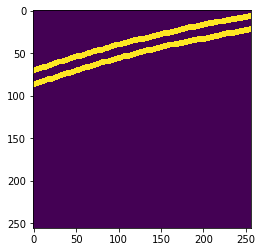

In [57]:
plt.imshow(array)

In [58]:
array.min()

0

In [59]:
import numpy as np
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
import matplotlib.pylab as plt


In [60]:
# Open tif file
ds = gdal.Open('0_10378780_15.tiff')
# GDAL affine transform parameters, 
#According to gdal documentation xoff/yoff are image left corner, 
#a/e are pixel wight/height and b/d is rotation and is zero if image is north up. 
# unravel GDAL affine transform parameters
c, a, b, f, d, e = ds.GetGeoTransform()

def pixel2coord(col, row):
    """Returns global coordinates to pixel center using base-0 raster index"""
    xp = (a) * col + b * row + c 
    yp = (d) * col + e * row + f
    return(xp, yp)

# get columns and rows of your image from gdalinfo
rows, colms = np.shape(array)

lat = np.empty(shape=(rows,colms))
lat.fill(0)

lon = np.empty(shape=(rows,colms))
lon.fill(0)

if __name__ == "__main__":
 for row in  range(0,rows):
    for col in  range(0,colms): 
        lon[row][col], lat[row][col] = pixel2coord(col,row)

In [61]:
# For each pixel I know it's latitude and longitude.
# As you'll see below you only really need the coordinates of
# one corner, and the resolution of the file.

xmin,ymin,xmax,ymax = [lon.min(),lat.min(),lon.max(),lat.max()]
nrows,ncols = np.shape(array)
xres = (xmax-xmin)/float(ncols)
yres = (ymax-ymin)/float(nrows)
geotransform=(xmin,xres,0,ymax,0, -yres)   
# That's (top left x, w-e pixel resolution, rotation (0 if North is up), 
#         top left y, rotation (0 if North is up), n-s pixel resolution)
# I don't know why rotation is in twice???

output_raster = gdal.GetDriverByName('GTiff').Create('myraster.tif',ncols, nrows, 1 ,gdal.GDT_Float32)  # Open the file
output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
srs = osr.SpatialReference()                 # Establish its coordinate encoding
srs.ImportFromEPSG(4326)                     # This one specifies WGS84 lat long.
                                             # Anyone know how to specify the 
                                             # IAU2000:49900 Mars encoding?
output_raster.SetProjection( srs.ExportToWkt() )   # Exports the coordinate system 
                                                   # to the file
output_raster.GetRasterBand(1).WriteArray(array)   # Writes my array to the raster

output_raster.FlushCache()